# Approximate Bayesian Computation

In [1]:
include("utils.jl"); using .Utils
checkpkgs("Statistics", "Plots", "DataFrames", "StatsPlots", "Interpolations", "Turing", "StatsBase")

## The Kidney Tumor Problem

## A Simple Growth Model

In [2]:
"""Converts a diameter to a volume."""
function calc_volume(diameter)
    factor = 4π / 3
    return factor * (diameter/2.0)^3
end

calc_volume

In [3]:
d1 = 1
v1 = calc_volume(d1)

0.5235987755982988

In [4]:
median_doubling_time = 811
rdt = 365 / median_doubling_time

0.45006165228113443

In [5]:
interval = 9.0
doublings = interval * rdt

4.05055487053021

In [6]:
v2 = v1 * 2^doublings
v2

8.676351488087187

In [7]:
"""Converts a volume to a diameter."""
function calc_diameter(volume)
    factor = 3 / π / 4
    return 2 * (factor * volume)^(1/3)
end

calc_diameter

In [8]:
d2 = calc_diameter(v2)

2.5494480788327483

## A More General Model

In [9]:
# Data from the histogram in Figure 3

include("empiricaldist.jl"); using .EmpiricalDist

cnts = [2, 29, 11, 6, 3, 1, 1]
rdts = -1:5  + 0.01
pmf_rdt = Pmf(cnts, rdts)
normalize!(pmf_rdt)

53.0

In [10]:
# Data from the scatter plot in Figure 4

rdts = [5.089,  3.572,  3.242,  2.642,  1.982,  1.847,  1.908,  1.798,
        1.798,  1.761,  2.703, -0.416,  0.024,  0.869,  0.746,  0.257,
        0.269,  0.086,  0.086,  1.321,  1.052,  1.076,  0.758,  0.587,
        0.367,  0.416,  0.073,  0.538,  0.281,  0.122, -0.869, -1.431,
        0.012,  0.037, -0.135,  0.122,  0.208,  0.245,  0.404,  0.648,
        0.673,  0.673,  0.563,  0.391,  0.049,  0.538,  0.514,  0.404,
        0.404,  0.33,  -0.061,  0.538,  0.306]

rdt_sample = rdts
length(rdt_sample)

53

In [11]:
qs = LinRange(-2, 6, 201)
pmf_rdt = kde_from_sample(rdt_sample, qs);

In [12]:
using Statistics
1 / median(pmf_rdt) * 365

760.4166666666667

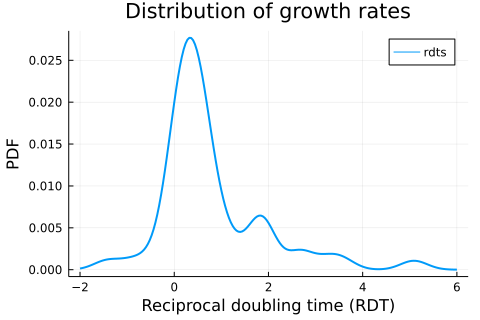

In [13]:
using Plots
plot(pmf_rdt, label="rdts",
     xlabel="Reciprocal doubling time (RDT)",
         ylabel="PDF",
         title="Distribution of growth rates")

## Simulation

In [14]:
interval = 245 / 365      # year
min_diameter = 0.3        # cm
max_diameter = 20;         # cm

In [15]:
v0 = calc_volume(min_diameter)
vmax = calc_volume(max_diameter)
v0, vmax

(0.014137166941154067, 4188.790204786391)

In [16]:
using DataFrames

"""Simulate the growth of a tumor."""
function simulate_growth(pmf_rdt)
    age = 0
    volume = v0
    res = Matrix{Float64}(undef, 0, 2)
    
    while true
        res = vcat(res, [age volume])
        if volume > vmax
            break
        end
        rdt = rand(pmf_rdt)
        age += interval 
        doublings = rdt * interval
        volume *= 2^doublings
    end

    cols = ["age", "volume"]
    sim = DataFrame(res, cols)
    sim.diameter = calc_diameter.(sim.volume)
    return sim
end

simulate_growth

In [17]:
import Random
Random.seed!(17)

MersenneTwister(17)

In [18]:
sim = simulate_growth(pmf_rdt);

In [19]:
first(sim, 3)

,age,volume,diameter
,Float64,Float64,Float64
1,0.0,0.0141372,0.3
2,0.671233,0.0124104,0.287251
3,1.34247,0.0158073,0.311377


In [20]:
last(sim, 3)

,age,volume,diameter
,Float64,Float64,Float64
1,32.8904,3351.13,18.5665
2,33.5616,3817.41,19.3905
3,34.2329,4430.25,20.3771


In [21]:
Random.seed!(17)

MersenneTwister(17)

In [22]:
sims = [simulate_growth(pmf_rdt) for _ in 1:101];

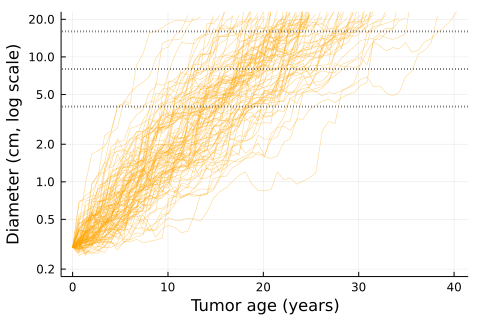

In [23]:
using StatsPlots

diameters = [4, 8, 16]
plot()
for sim in sims
    @df sim plot!(:age, :diameter,
             color=:orange, linewidth=0.5, alpha=0.5)
end
hline!(diameters, ls=:dot, c=:gray)

yt = [0.2, 0.5, 1, 2, 5, 10, 20]
plot!(xlabel="Tumor age (years)",
         ylabel="Diameter (cm, log scale)",
         ylim=[0.2, 20],
         yaxis=:log10,
         yticks=(yt, yt))

In [24]:
using Interpolations

function interp_helper(x, y)
    # LinearInterpolation is finicky about its inputs. In particular
    # `x` must be strickly increasing    
    p = sortperm(x)
    x, y = x[p], y[p]
    Interpolations.deduplicate_knots!(x)
    return LinearInterpolation(x, y)
end

"""Estimate the age when each tumor reached a given size."""
function interpolate_ages(sims, diameter)
    ages = []
    for (i, sim) in enumerate(sims)
        interp = interp_helper(sim.diameter, sim.age)
        age = interp(diameter)
        push!(ages, age)
    end
    return ages
end

interpolate_ages

In [25]:
ages = interpolate_ages(sims, 15)
cdf = cdffromseq(ages)
median(cdf), credibleinterval(cdf, 0.9)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.30000000000000004, 0.31919990398875714, 0.3704438128859259, 0.5243179556260107, 0.5374911645928239, 0.5578741369846801, 0.5613456709347227, 0.5754491814982892, 0.589907035242031, 0.6514633246737795, 0.6555172445436565, 0.6719867656635523, 0.714993703605071, 0.8828833125096404, 0.9106973165815044, 1.1245406211314457, 1.2418854633127643, 1.346187303080276, 2.730477232569024, 3.072043808107861, 3.499488324868273, 3.6321974345434977, 3.769939196468377, 3.7933987387602532, 3.7933987387602537, 3.7933987387602537, 3.864656907914981, 4.011214098520527, 4.1119937131864965, 4.429780823902831, 4.56933487382962, 4.626379841185398, 4.742615167009826, 6.838686891939408, 7.054130158748836, 7.8874780552642685, 7.936560179768308, 9.442098054793115, 9.739558149487213, 10.362886754030782, 11.37347030857748, 12.875852496675122, 13.61517853037863, 14.39695635391531, 16.4

(0.504950495049505, [13.814695827286258, 31.107746029704167])

In [26]:
1 - cdf(9.0)

0.9864588558571726

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.30000000000000004, 0.31919990398875714, 0.3704438128859259, 0.5243179556260107, 0.5374911645928239, 0.5578741369846801, 0.5613456709347227, 0.5754491814982892, 0.589907035242031, 0.6514633246737795, 0.6555172445436565, 0.6719867656635523, 0.714993703605071, 0.8828833125096404, 0.9106973165815044, 1.1245406211314457, 1.2418854633127643, 1.346187303080276, 2.730477232569024, 3.072043808107861, 3.499488324868273, 3.6321974345434977, 3.769939196468377, 3.7933987387602532, 3.7933987387602537, 3.7933987387602537, 3.864656907914981, 4.011214098520527, 4.1119937131864965, 4.429780823902831, 4.56933487382962, 4.626379841185398, 4.742615167009826, 6.838686891939408, 7.054130158748836, 7.8874780552642685, 7.936560179768308, 9.442098054793115, 9.739558149487213, 10.362886754030782, 11.37347030857748, 12.875852496675122, 13.61517853037863, 14.39695635391531, 16.4

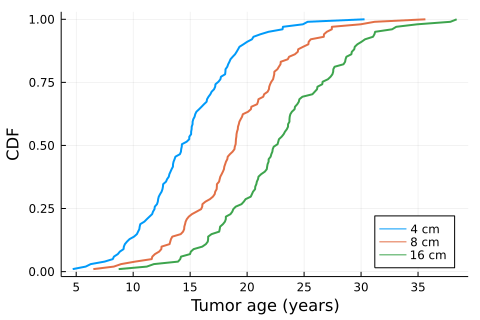

In [27]:
plot()
for diameter in diameters
    ages = interpolate_ages(sims, diameter)
    c = cdffromseq(ages)
    plot!(c, label="$(diameter) cm")
end
    
plot!(xlabel="Tumor age (years)",
         ylabel="CDF", legend=:bottomright)

## Approximate Bayesian Calculation

## Counting Cells

In [28]:
total_squares = 25
squares_counted = 5
yeast_counted = 49;

In [29]:
using Turing
billion = 1e9

@model function model1(count)
    # Normal -> TruncatedNormal to ensure vol >= 0
    yeast_conc ~ TruncatedNormal(2billion, 0.4billion, 0, Inf)
    shaker1_vol ~ TruncatedNormal(9.0, 0.05, 0, Inf)
    shaker2_vol ~ TruncatedNormal(9.0, 0.05, 0, Inf)
    shaker3_vol ~ TruncatedNormal(9.0, 0.05, 0, Inf)

    yeast_slurry_vol ~ TruncatedNormal(1.0, 0.01, 0, Inf)
    shaker1_to_shaker2_vol ~ TruncatedNormal(1.0, 0.01, 0, Inf)
    shaker2_to_shaker3_vol ~ TruncatedNormal(1.0, 0.01, 0, Inf)

    dilution_shaker1 = (yeast_slurry_vol / 
                        (yeast_slurry_vol + shaker1_vol))
    dilution_shaker2 = (shaker1_to_shaker2_vol / 
                        (shaker1_to_shaker2_vol + shaker2_vol))
    dilution_shaker3 = (shaker2_to_shaker3_vol / 
                        (shaker2_to_shaker3_vol + shaker3_vol))
    
    final_dilution = (dilution_shaker1 * 
                      dilution_shaker2 * 
                      dilution_shaker3)
    
    chamber_vol ~ Gamma(400, 2.5e-7)
    
    yeast_in_chamber ~ Poisson(yeast_conc * final_dilution * chamber_vol)
    cnt ~ Binomial(yeast_in_chamber, squares_counted/total_squares)
end

model1 (generic function with 2 methods)

In [30]:
trace = sample(model1(yeast_counted), PG(50), 500)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05


Chains MCMC chain (500×12×1 Array{Float64, 3}):

Log evidence      = 0.0
Iterations        = 1:1:500
Number of chains  = 1
Samples per chain = 500
Wall duration     = 15.43 seconds
Compute duration  = 15.43 seconds
parameters        = yeast_conc, shaker1_vol, shaker2_vol, shaker3_vol, yeast_slurry_vol, shaker1_to_shaker2_vol, shaker2_to_shaker3_vol, chamber_vol, yeast_in_chamber, cnt
internals         = lp, logevidence

Summary Statistics
              parameters              mean              std        naive_se    ⋯
                  Symbol           Float64          Float64         Float64    ⋯

              yeast_conc   1999491078.0730   395877827.0074   17704194.6395    ⋯
             shaker1_vol            9.0002           0.0477          0.0021    ⋯
             shaker2_vol            8.9984           0.0530          0.0024    ⋯
             shaker3_vol            9.0004           0.0513          0.0023    ⋯
        yeast_slurry_vol            0.9993           0.0102          0

In [31]:
posterior_sample = vec(trace[:yeast_conc] / billion)
cdf_turing = cdffromseq(posterior_sample)

mean(cdf_turing), credibleinterval(cdf_turing, 0.9)

(1.9994910780729713, [1.3722381561606452, 2.691618592271739])

## Cell Counting with ABC

In [32]:
prior_sample = sample(model1(missing), Prior(), 10000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


In [33]:
cnt = prior_sample[:cnt]
mean(cnt)

40.1468

In [34]:
mask = (cnt .== 49)
count(mask)

249

In [35]:
posterior_sample2 = prior_sample[:yeast_conc][mask] / billion;

In [36]:
cdf_abc = cdffromseq(posterior_sample2)
mean(cdf_abc), credibleinterval(cdf_abc, 0.9)

(2.276142885219215, [1.8936913543470553, 2.6709941008611398])

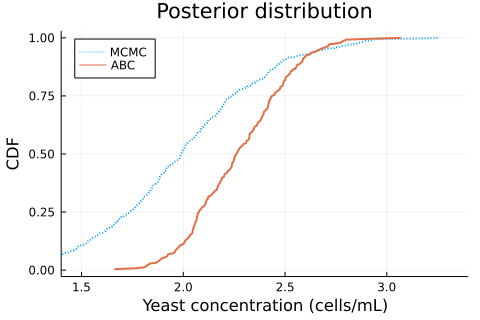

In [37]:
plot(cdf_turing, label="MCMC", style=:dot)
plot!(cdf_abc, label="ABC")

plot!(xlabel="Yeast concentration (cells/mL)",
         ylabel="CDF", legend=:topleft,
         title="Posterior distribution",
         xlim=(1.4, 3.4))

## When Do We Get to the Approximate Part?

In [38]:
n = prior_sample[:yeast_in_chamber]
size(n)

(10000, 1)

In [39]:
p = squares_counted/total_squares
p

0.2

In [40]:
likelihood = pdf.(Binomial.(vec(n), p),yeast_counted);

In [41]:
size(likelihood)

(10000,)

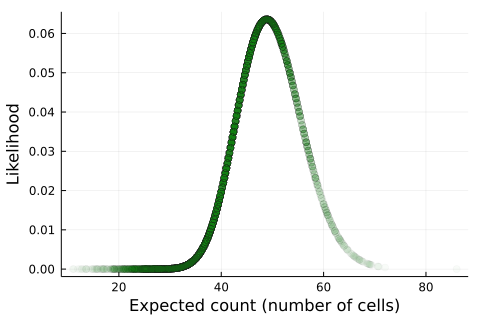

In [42]:
scatter(n*p, likelihood, markertype=:dot, alpha=0.03, color=:green,
        xlabel="Expected count (number of cells)",
         ylabel="Likelihood")

In [43]:
qs = vec(prior_sample[:yeast_conc] / billion)
ps = likelihood
posterior_pmf = Pmf(ps, qs);

In [44]:
function Base.sort!(x::Pmf)
    p = sortperm(x.qs)
    x.qs .= x.qs[p]
    x.ps .= x.ps[p]
    x
end

sort!(posterior_pmf)
normalize!(posterior_pmf)

mean(posterior_pmf), credibleinterval(posterior_pmf, 0.9)

(2.2718109572389116, [1.8604274361296524, 2.7111680906661277])

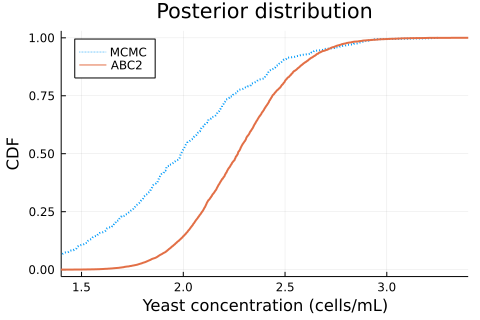

In [45]:
plot(cdf_turing, label="MCMC", style=:dot)
plot!(makecdf(posterior_pmf), label="ABC2")

plot!(xlabel="Yeast concentration (cells/mL)",
         ylabel="CDF", legend=:topleft,
         title="Posterior distribution",
         xlim=(1.4, 3.4))

## Summary

## Exercises

In [46]:
μ = 30
p = 0.8666666
r = μ * (1-p) / p

prior_n_socks = NegativeBinomial(r, 1-p)
mean(prior_n_socks), std(prior_n_socks)

(30.0, 14.999996250001404)

In [47]:
prior_prop_pair = Beta(15, 2)
mean(prior_prop_pair)

0.8823529411764706

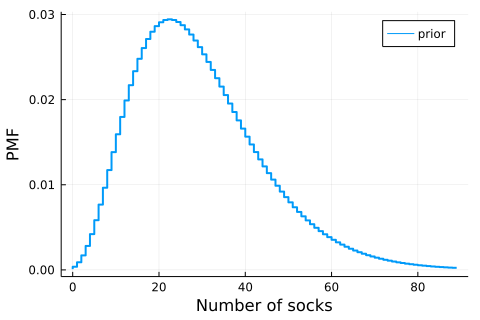

In [48]:
qs = 0:89
ps = pdf(prior_n_socks, qs)
pmf = Pmf(ps, qs)
normalize!(pmf)

plot(pmf, label="prior", linetype=:steppre,
        xlabel="Number of socks",
         ylabel="PMF")

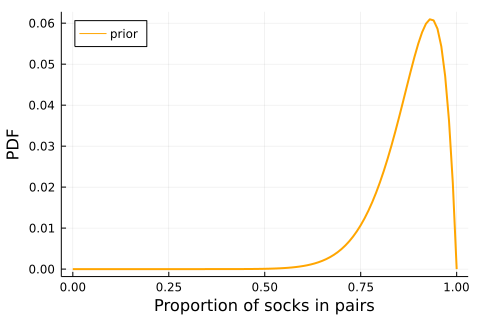

In [49]:
qs = LinRange(0, 1, 101)
pmf = pmffromdist(prior_prop_pair, qs)
plot(pmf, label="prior", color=:orange, 
        xlabel="Proportion of socks in pairs",
         ylabel="PDF", legend=:topleft)

In [50]:
n_socks = rand(prior_n_socks)
prop_pairs = rand(prior_prop_pair)

n_socks, prop_pairs

(93, 0.8185858566599479)

In [51]:
n_pairs = round(floor(n_socks/2) * prop_pairs)
n_odds = n_socks - n_pairs*2

n_pairs, n_odds

(38.0, 17.0)

In [52]:
# Solution

n_pairs = 9
n_odds = 5

socks = vcat(1:n_pairs, 1:(n_pairs+n_odds))

23-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14

In [53]:
# Solution

picked_socks = sample(socks, 11, replace=false)

11-element Vector{Int64}:
  6
  6
  7
 14
  9
 12
  3
 11
  4
  1
  7

In [54]:
# Solution
using StatsBase

dict = countmap(picked_socks)
vals, cnts = keys(dict), values(dict)
vals

KeySet for a Dict{Int64, Int64} with 9 entries. Keys:
  4
  6
  7
  11
  9
  12
  14
  3
  1

In [55]:
# Solution

cnts

ValueIterator for a Dict{Int64, Int64} with 9 entries. Values:
  1
  2
  2
  1
  1
  1
  1
  1
  1

In [56]:
# Solution

solo = count(cnts.==1)
pairs = count(cnts.==2)

solo, pairs

(7, 2)

In [57]:
# Solution

function pick_socks(n_pairs, n_odds, n_pick)
    socks = vcat(1:n_pairs, 1:(n_pairs + n_odds))
    
    picked_socks = sample(socks, n_pick, replace=false)
    
    dict = countmap(picked_socks)
    vals, cnts = keys(dict), values(dict)

    pairs = count(cnts.==2)
    odds = count(cnts.==1)
    
    return pairs, odds
end

pick_socks (generic function with 1 method)

In [58]:
# Solution

pick_socks(n_pairs, n_odds, 11)

(2, 7)

In [59]:
# Solution

data = (0, 11)
res = Tuple{Int, Int, Int}[]
for i in 1:10000
    n_socks = rand(prior_n_socks)
    if n_socks < 11
        continue
    end
    prop_pairs = rand(prior_prop_pair)
    n_pairs = round(Int, floor(n_socks/2) * prop_pairs)
    n_odds = n_socks - n_pairs*2
    result = pick_socks(n_pairs, n_odds, 11)
    if result == data
        push!(res, (n_socks, n_pairs, n_odds))
    end
end

length(res)

1106

In [60]:
# Solution

res = reinterpret(reshape, Int, res)'
cols = ["n_socks", "n_pairs", "n_odds"]
results = DataFrame(res, cols)
first(results, 5)

,n_socks,n_pairs,n_odds
,Int64,Int64,Int64
1,53,24,5
2,61,27,7
3,64,31,2
4,32,13,6
5,25,9,7


In [61]:
# Solution

qs = 15:99
posterior_n_socks = pmffromseq(results.n_socks)
median(posterior_n_socks),
      credibleinterval(posterior_n_socks, 0.9)

(43, [26, 77])

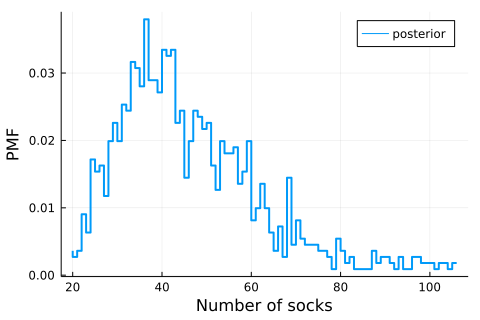

In [62]:
# Solution

plot(posterior_n_socks, label="posterior", linetype=:steppre,
    xlabel="Number of socks",
         ylabel="PMF")